# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.keras.DenseNNWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.keras.DenseNNWorkflow --monotonic --max-evals 100 -t 3600 --initial-configs configs.csv --verbose
```
this will create the `results.csv` file.

In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [2]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,activation,batch_size,learning_rate,num_epochs,num_units,optimizer,shuffle_each_epoch,transform_cat,transform_real
0,relu,32,0.001000,10,32,Adam,True,onehot,none
1,softplus,48,2.303917,4,1,SGD,True,ordinal,std
2,sigmoid,1,0.000188,21,37,SGD,True,onehot,minmax
3,sigmoid,1,0.566502,25,3,Adamax,True,onehot,minmax
4,softsign,108,0.000930,10,1,Nadam,False,onehot,none
...,...,...,...,...,...,...,...,...,...
95,none,111,0.562420,98,101,Nadam,True,ordinal,minmax
96,tanh,221,0.019489,1,1,RMSprop,False,onehot,none
97,selu,3,9.692931,24,17,SGD,False,ordinal,std
98,softsign,12,0.000096,19,124,RMSprop,False,ordinal,none


In [3]:
def prepare_df(df):
    """Prepare the dataframe for analysis. For example, load the arrays/list from json format.
    """

    # Convert the string to JSON
    str_to_json = lambda x: x.replace("'", '"').replace("nan", "NaN").replace("inf", "Infinity")
    load_json = lambda x: json.loads(str_to_json(x))
    load_array = lambda x: np.array(load_json(x))

    # Load the arrays
    columns = ["m:fidelity_values", "m:score_types", "m:score_values"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_array)

    # Load the dicts
    columns = ["m:child_fidelities"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_json)

    return df

In [4]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df = pd.read_csv("results.csv")
r_df.sort_values("job_id", inplace=True)

r_df = prepare_df(r_df)

r_df

,p:activation,p:batch_size,p:learning_rate,p:num_epochs,p:num_units,p:optimizer,p:shuffle_each_epoch,p:transform_cat,p:transform_real,objective,...,m:time_types,m:time_values,m:child_fidelities,m:dataset_id,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed
2,relu,32,0.001000,10,32,Adam,True,onehot,none,0.99062,...,"['fit', 'predict']","[[1.6413648128509521, 0.1609039306640625], [1....","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
1,softplus,48,2.303917,4,1,SGD,True,ordinal,std,0.47812,...,"['fit', 'predict']","[[1.2938458919525146, 0.16174602508544922], [0...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
55,sigmoid,1,0.000188,21,37,SGD,True,onehot,minmax,0.52500,...,"['fit', 'predict']","[[6.580114126205444, 0.19196605682373047], [10...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
62,sigmoid,1,0.566502,25,3,Adamax,True,onehot,minmax,0.99062,...,"['fit', 'predict']","[[8.089684247970581, 0.18585705757141113], [7....","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
3,softsign,108,0.000930,10,1,Nadam,False,onehot,none,0.65938,...,"['fit', 'predict']","[[2.138913154602051, 0.1575469970703125], [1.6...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,tanh,221,0.019489,1,1,RMSprop,False,onehot,none,0.71875,...,"['fit', 'predict']","[[1.0571949481964111, 0.12411785125732422], [1...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
94,selu,3,9.692931,24,17,SGD,False,ordinal,std,0.47812,...,"['fit', 'predict']","[[3.007503032684326, 0.11428594589233398], [0....","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
93,softsign,88,0.000314,5,16,Adadelta,True,ordinal,std,0.45625,...,"['fit', 'predict']","[[1.3213651180267334, 0.09860396385192871], [1...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42
98,elu,128,0.097083,9,1,Adam,True,onehot,none,0.95938,...,"['fit', 'predict']","[[1.4338290691375732, 0.12146902084350586], [1...","[{'fidelity_unit': 'epochs', 'fidelity_values'...",3,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42


In [5]:
# Check the columns
r_df.columns.to_list()

['p:activation',
 'p:batch_size',
 'p:learning_rate',
 'p:num_epochs',
 'p:num_units',
 'p:optimizer',
 'p:shuffle_each_epoch',
 'p:transform_cat',
 'p:transform_real',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:child_fidelities',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed']

In [19]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.\n")

# Best score with full data
best_score = np.concatenate(r_df["m:score_values"].map(lambda x: x[:, 1, 0]).values, axis=0).max()
print(f"Best score: {best_score:.3f}")

Cumulated time (without submit/gather overheads): 7144.67 s.
Cumulated time (with submit/gather overheads)   : 7192.44 s.
Overheads accounted for 0.67 % of the total time.

Real time of execution: 754.70 s.

Best score: 0.997


In [7]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 72.17 s.
Std  time per job: 104.73 s.


In [8]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


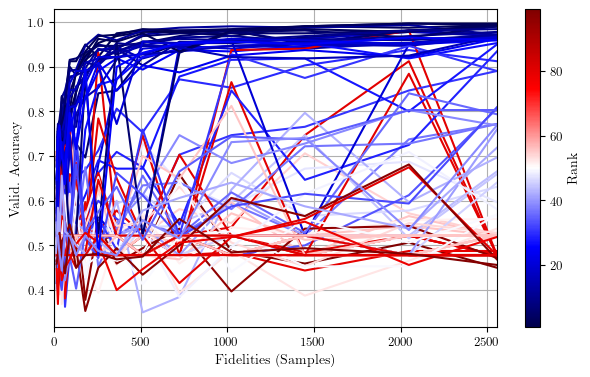

In [9]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure(figsize=figsize)

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()

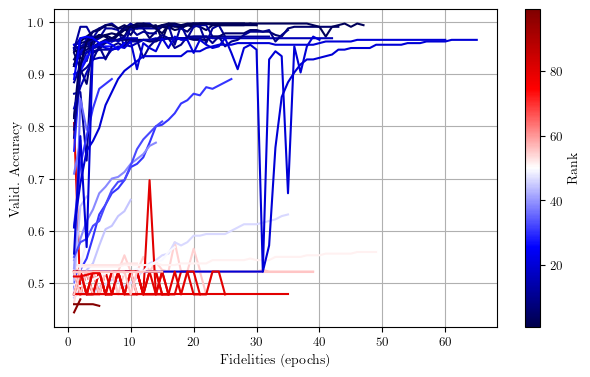

In [10]:
selected_score = "accuracy"
selected_split = "valid"

# First index of "x" is the parent-fidelity over "samples"
# First index of "x[-1]["score_values"]" is the current fidelity over "epochs"
# Second index of "x[-1]["score_values"]" is the split (train, valid, test) # TODO!!!! correct this is not currently the case
# Third index of "x[-1]["score_values"]" is the score type (accuracy, loss, etc.)

# Selecting the "epoch"-curves for the maximum fidelity of "sample"-curves -> -1
# Ranking by the performance at the last epoch -> -1
# e.g., r_df["m:child_fidelities"].map(lambda x: np.asarray(x[-1]["score_values"])[-1, 3])

# Plotting
score_types = r_df["m:child_fidelities"][0][-1]["score_types"]
splits = ["train", "valid"]
unit = r_df["m:child_fidelities"][0][-1]["fidelity_unit"]

idx_split = splits.index(selected_split) 
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure(figsize=figsize)

scores_max_fidelity = r_df["m:child_fidelities"].map(lambda x: np.asarray(x[-1]["score_values"])[-1, idx_split, idx_score])
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()

for i in range(len(r_df)):
    fidelities = np.asarray(r_df.iloc[i]["m:child_fidelities"][-1]["fidelity_values"])
    scores = np.asarray(r_df.iloc[i]["m:child_fidelities"][-1]["score_values"])[:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
# plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()

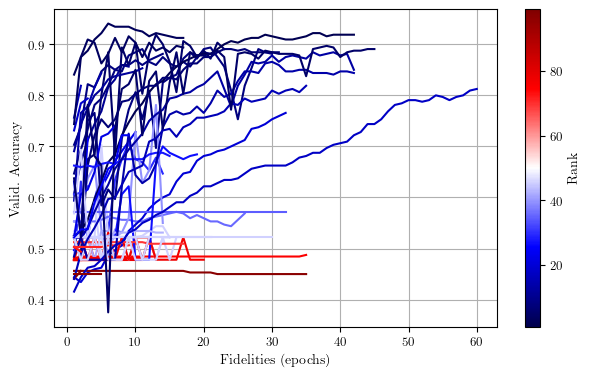

In [16]:
selected_score = "accuracy"
selected_split = "valid"
fidelity_values = 128  # To select the "anchor"

# First index of "x" is the parent-fidelity over "samples"
# First index of "x[-1]["score_values"]" is the current fidelity over "epochs"
# Second index of "x[-1]["score_values"]" is the split (train, valid, test) 
# Third index of "x[-1]["score_values"]" is the score type (accuracy, loss, etc.)

# Selecting the "epoch"-curves for the maximum fidelity of "sample"-curves -> -1
# Ranking by the performance at the last epoch -> -1
# e.g., r_df["m:child_fidelities"].map(lambda x: np.asarray(x[-1]["score_values"])[-1, 3])

# Plotting
score_types = r_df["m:child_fidelities"][0][-1]["score_types"]
splits = ["train", "valid"]
unit = r_df["m:child_fidelities"][0][-1]["fidelity_unit"]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)
idx_fidelity = r_df["m:fidelity_values"][0].tolist().index(fidelity_values)

cmap = mpl.colormaps["seismic"]

fig = plt.figure(figsize=figsize)

# The -1 index here is for "epoch"-fidelity (i.e., -1 is the last epoch for
# the current "sample"-fidelity).
scores_max_fidelity = r_df["m:child_fidelities"].map(
    lambda x: np.asarray(x[idx_fidelity]["score_values"])[
        -1, idx_split, idx_score
    ]
)
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()

for i in range(len(r_df)):
    fidelities = np.asarray(
        r_df.iloc[i]["m:child_fidelities"][idx_fidelity]["fidelity_values"]
    )
    scores = np.asarray(
        r_df.iloc[i]["m:child_fidelities"][idx_fidelity]["score_values"]
    )[:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i] / ranking_max))

plt.xlabel(f"Fidelities ({unit})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
# plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()